In [1]:
from sklearn import svm, datasets
from sklearn.linear_model import HuberRegressor
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
import time
import numpy as np
import MEArecTemplate as mr
from pathlib import Path
import MEAutility as mu
import LFPy
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as pltcolors
import matplotlib

In [2]:
%run ZIAD_MEARecHelperFunctions.ipynb

In [3]:
# Get all signals from the grid of electrodes that exceed a certain threshold
def get_strong_signals(data, elec_x, elec_y, thresh):
    data = data/np.max(abs(data))
    
    coords = []
    targets = []
    for i in range(len(data)):
        if np.max(abs(data[i])) >= thresh:
            coords.append([elec_x[i], elec_y[i]])
            
            # Target is 1 if signal is positive, 0 if negative
            targets.append(np.max(data[i]) > abs(np.min(data[i])))
            
    return np.array(coords), np.array(targets)

def get_electrodes(mea_name):
    mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
    cell_name = 'L5_TTPC1_cADpyr232_1'
    cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
    
    cell = mr.return_bbp_cell(cell_model_folder, end_T=1000, dt=0.03125, start_T=0)
    mea = mu.return_mea(mea_name)
    electrodes = LFPy.RecExtElectrode(cell, probe=mea)
    
    return electrodes

def get_electrodes2(mea_name):
    m_idx = mea_name.find('MEA')
    count = int(np.sqrt(int(mea_name[:m_idx])))
    pitch = int(mea_name[m_idx+3:])
    
    max_coord = (count - 1)*pitch/2.0
    coords = np.arange(-1*max_coord, max_coord+1, pitch)
    
    elec_x = []
    elec_y = []
    for xcoord in coords:
        for ycoord in coords:
            elec_x.append(xcoord)
            elec_y.append(ycoord)
    
    return np.array(elec_x), np.array(elec_y)

def make_meshgrid(x, y, h=.5):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out, Z

def load_cell(template_id, tempgen):
    # Load cell and position and rotation info
    mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
    cell_name = 'L5_TTPC1_cADpyr232_1'
    cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
    
    T = 1000
    dt = 0.03125
    cell = mr.return_bbp_cell(cell_model_folder, end_T=T, dt=dt, start_T=0)

    pos = tempgen.locations[template_id]
    rot = tempgen.rotations[template_id]

    cell = mr.ziad_flatten_geometry(cell, pos, rot, 10)
    cell.set_pos(pos[0], pos[1], pos[2])
    cell.set_rotation(rot[0], rot[1], rot[2])

    return cell

def get_apic_dist(template_id, all_y, all_z, clf, verbose=False):
    coords = np.zeros((2, np.shape(all_y)[1]))
    coords[0] = all_y[template_id]
    coords[1] = all_z[template_id]
    dists = abs(clf.decision_function(coords.T))/np.linalg.norm(clf.coef_)
    if verbose:
        print(dists)
    
    return np.mean(dists), np.std(dists)

def get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = [], verbose=False):
    coords = np.zeros((np.shape(all_y)[1], 2))
    coords[:, 0] = all_y[template_id]
    coords[:, 1] = all_z[template_id]
    
    if len(boundary) == 0:
        dists = distance.cdist(coords, get_boundary_coords(xx, yy, clf), 'euclidean')
    else:
        dists = distance.cdist(coords, boundary, 'euclidean')
        
    dists = np.min(dists, axis=1)
#     if verbose:
#         print(dists)
#         plt.hist(dists, bins=30)
        
    return np.mean(dists), np.std(dists), dists

def get_boundary_coords(xx, yy, clf):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    boundary = []
    for i in range(len(xx)):
        for j in range(1, len(xx[0])):
            if j > 0:
                if Z[i, j] != Z[i, j-1]:
                    #print("hit1")
                    midx = (xx[i, j] + xx[i, j-1]) / 2
                    midy = yy[i, j]
                    boundary.append([midx, midy])
            if i > 0:
                if Z[i, j] != Z[i-1, j]:
                    #print("hit2")
                    midx = xx[i, j]
                    midy = (yy[i, j] + yy[i-1, j]) / 2
                    boundary.append([midx, midy])
    #print(boundary)
    boundary = np.array(boundary)
    return boundary

def generate_noise(snr, sig, shape):
    noise = np.random.normal(size=shape)
    
    sig_pwr = np.sum(sig**2)
    noise_pwr = sig_pwr/(10**(snr/10))
    noise_coeff = np.sqrt(noise_pwr/np.sum(noise**2))
    noise = noise*noise_coeff
    
    new_noise_pwr = np.sum(noise**2)
    
    #print("SNR: ", 10*np.log10(sig_pwr/noise_pwr))
    return noise

def estimate_axon_hillock(signals, elec_x, elec_y, return_med = False):
    mags_pwr = np.sqrt(np.sum(signals**2, axis=1))
    mags_strong_indices = np.argsort(-1*mags_pwr)[:4]
    
    mags_relative_pwr = mags_pwr[mags_strong_indices] / np.sum(mags_pwr[mags_strong_indices])

    new_x = np.sum(elec_x[mags_strong_indices] * mags_relative_pwr)
    new_y = np.sum(elec_y[mags_strong_indices] * mags_relative_pwr)
    
    # Returns coordinates of other strong points
    if return_med:
        new_coords = []
        indices = np.arange(10, 100, 10)
        #indices = np.arange(4, 17, 4)
        for index in indices:
            mags_med_indices = np.argsort(-1*mags_pwr)[index:index+4]

            mags_relative_pwr_med = mags_pwr[mags_med_indices] / np.sum(mags_pwr[mags_med_indices])

            med_x = np.sum(elec_x[mags_med_indices] * mags_relative_pwr_med)
            med_y = np.sum(elec_y[mags_med_indices] * mags_relative_pwr_med)
            
            new_coords.append([med_x, med_y])
        
        return new_x, new_y, np.array(new_coords)
    
    return new_x, new_y

def get_lbf_points(signals, indices, elec_x, elec_y):
    mags_pwr = np.sqrt(np.sum(signals**2, axis=1))
    
    new_coords = []
    #indices = np.arange(10, 100, 10)
    #indices = np.arange(4, 17, 4)
    for index in indices:
        mags_med_indices = np.argsort(-1*mags_pwr)[index:index+4]

        mags_relative_pwr_med = mags_pwr[mags_med_indices] / np.sum(mags_pwr[mags_med_indices])

        med_x = np.sum(elec_x[mags_med_indices] * mags_relative_pwr_med)
        med_y = np.sum(elec_y[mags_med_indices] * mags_relative_pwr_med)

        new_coords.append([med_x, med_y])
        
    return np.array(new_coords)

def cast_lbf_to_boundary(lbf_coords, boundary):
    dists = distance.cdist(lbf_coords, boundary, 'euclidean')
    min_coord_idxs = np.argmin(dists, axis=1)
    cast_coords = boundary[min_coord_idxs]
    return cast_coords

def calc_lbf(ah_x, ah_y, point_coords, loss_func, weight, eps = 1.35):
    x = np.zeros((len(point_coords[:, 0]) + 1,))
    y = np.zeros((len(point_coords[:, 1]) + 1,))
    x[0] = ah_x
    y[0] = ah_y
    x[1:] = point_coords[:, 0]
    y[1:] = point_coords[:, 1]
    weights = np.ones((len(x),))
    weights[0] = weight
    
    if loss_func == 'Huber':
        huber = HuberRegressor(epsilon = eps)
        try:
            huber.fit(x[:, None], y, sample_weight = weights)
        except ValueError as e:
            print(f"Value error with eps = {eps} - retrying with different epsilon")
            return -1e8, -1e8
        y1 = huber.predict([[0]])
        y2 = huber.predict([[1]])
        m = (y2 - y1)
        b = y1
        
    elif loss_func == 'Normal':
        m, b = np.polyfit(x, y, 1, w = weights)
        
    return m, b

def load_cell(template_id, tempgen):
    # Load cell and position and rotation info
    mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
    cell_name = 'L5_TTPC1_cADpyr232_1'
    cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
    
    T = 1000
    dt = 0.03125
    cell = mr.return_bbp_cell(cell_model_folder, end_T=T, dt=dt, start_T=0)
    
    pos = tempgen.locations[template_id]
    rot = tempgen.rotations[template_id]

    cell = mr.ziad_flatten_geometry(cell, pos, rot, 10)
    cell.set_pos(pos[0], pos[1], pos[2])
    cell.set_rotation(rot[0], rot[1], rot[2])

    return cell

def remove_outliers(n_neighbors, cast_coords, max_range):
    # Remove outliers
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(cast_coords)
    distances, indices = nbrs.kneighbors(cast_coords)
    avg_dists = np.mean(distances[:, 1:], axis=1)
    
    cast_coords_no_outliers = []
    for i in range(len(avg_dists)):
        if avg_dists[i] < max_range:
            cast_coords_no_outliers.append(cast_coords[i])
    return np.array(cast_coords_no_outliers)

def gen_modified_coords(clf, signals, elec_x, elec_y, xx, yy, coords, params):
    
    min_dist = params['min_dist']
    max_dist = params['max_dist']
    num_points = params['num_points']
    
    opp_dist = params['opp_dist']
    
    # Get boundary estimation (true/false values assigned to dense coordinate map) and cast to boolean
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = (Z != 0)
    
    # Estimate axon hillock as well as direction of neuron
    ah_x, ah_y, new_coords = estimate_axon_hillock(signals, elec_x, elec_y, return_med = True)
    
    # Calculate line of best fit - assign half the points to be identical (axon hillock)
    mult = 2
    fit_coords = np.zeros((len(new_coords)*(mult+1), 2))
    fit_coords[:len(new_coords)*mult, 0] = ah_x
    fit_coords[:len(new_coords)*mult, 1] = ah_y
    fit_coords[len(new_coords)*mult:, 0] = new_coords[:, 0]
    fit_coords[len(new_coords)*mult:, 1] = new_coords[:, 1]
    m, b = np.polyfit(fit_coords[:, 0], fit_coords[:, 1], 1)
    
    # Find points above line
    q = yy > (xx*m + b)
    
    # Determine whether points above line are mostly in category 0 or 1 of SVM
    greater_than_category = np.sum(q & Z)/np.sum(q) > 0.5
    
    # Generate points close to axon_hillock along line of best fit at specified distances
    nearby_dists = np.linspace(min_dist, max_dist, num_points)

    # Find closest point to (ah_x, ah_y) on line
    b2 = ah_y + ah_x/m
    ah_x2 = (b2 - b)/(m + 1/m)
    ah_y2 = m*ah_x2 + b

    # Get nearby points along line of best fit
    nearby_x = nearby_dists/np.sqrt(1 + m**2) + ah_x2
    nearby_y = m*nearby_x + b

    # Get one point one either side of each of those points along the line perpendicular to line of best fit
    b_vals = nearby_y + nearby_x/m
    opposite_dists = np.arange(-1*opp_dist, opp_dist + 0.1, 2*opp_dist)
    opposite_x = np.add.outer(opposite_dists/np.sqrt(1 + (1/m)**2), nearby_x)
    b_vals = np.ones(np.shape(opposite_x)) * b_vals
    opposite_y = -1*opposite_x / m + b_vals

    # Generate modified coordinates and targets
    mod_coords = np.zeros((len(coords)+np.shape(opposite_x)[1]*np.shape(opposite_x)[0], 2))
    mod_coords[:len(coords), :] = coords
    mod_coords[len(coords):len(coords)+len(opposite_x[0]), 0] = opposite_x[0, :]
    mod_coords[len(coords):len(coords)+len(opposite_x[0]), 1] = opposite_y[0, :]
    mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 0] = opposite_x[1, :]
    mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 1] = opposite_y[1, :]

    mod_targets = np.zeros((len(mod_coords),))
    mod_targets[:len(targets)] = targets[:]
    mod_targets[len(targets):np.shape(opposite_x)[1] + len(targets)] = not greater_than_category
    mod_targets[len(targets) + np.shape(opposite_x)[1]:np.shape(opposite_x)[1]*2 + len(targets)] = greater_than_category

    return mod_coords, mod_targets

def gen_modified_coords2(clf, signals, elec_x, elec_y, xx, yy, coords, boundary, params):
    
    min_dist = params['min_dist']
    max_dist = params['max_dist']
    num_points = params['num_points']
    
    opp_dist = params['opp_dist']
    weight = params['weight']
    eps = params['epsilon']
    max_range = params['max_range']
    
    # Get boundary estimation (true/false values assigned to dense coordinate map) and cast to boolean
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = (Z != 0)
    
    ah_x, ah_y, new_coords = estimate_axon_hillock(signals, elec_x, elec_y, return_med = True)

    indices = np.arange(4, 200, 4)
    new_coords = get_lbf_points(signals, indices, elec_x, elec_y)
    cast_coords = cast_lbf_to_boundary(new_coords, boundary)
    cast_coords = remove_outliers(4, cast_coords, max_range)
    m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight, eps = eps)
    
#     for i in range(3):
#         m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Huber', weight, eps = eps)
#         if m != -1e8 and b != -1e8:
#             break
#         else:
#             eps += 0.05
            
#     if m == -1e8 and b == -1e8:
#         m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight, eps = eps)

    q = yy > (xx*m + b)
    greater_than_category = np.sum(q & Z)/np.sum(q) > 0.5

    # Points close to axon_hillock along line of best fit
    nearby_dists = np.linspace(min_dist, max_dist, num_points)
    #nearby_dists = np.arange(-5, 5.1, 0.01)*5

    # Find closest point to (ah_x, ah_y) on line
    b2 = ah_y + ah_x/m
    ah_x2 = (b2 - b)/(m + 1/m)
    ah_y2 = m*ah_x2 + b
    #print(ah_x, ah_x2)

    # Get nearby points along line of best fit
    nearby_x = nearby_dists/np.sqrt(1 + m**2) + ah_x2
    nearby_y = m*nearby_x + b

    #print(np.sqrt((nearby_x - ah_x2)**2 + (nearby_y - (ah_y2))**2))

    # Get one point one either side of each of those points along the line perpendicular to line of best fit
    b_vals = nearby_y + nearby_x/m
    opposite_dists = np.arange(-2, 2.1, 4)*5
    opposite_x = np.add.outer(opposite_dists/np.sqrt(1 + (1/m)**2), nearby_x)
    b_vals = np.ones(np.shape(opposite_x)) * b_vals
    opposite_y = -1*opposite_x / m + b_vals

    # Re-calculate SVM with modified coordinates
    mod_coords = np.zeros((len(coords)+np.shape(opposite_x)[1]*np.shape(opposite_x)[0], 2))
    mod_coords[:len(coords), :] = coords
    mod_coords[len(coords):len(coords)+len(opposite_x[0]), 0] = opposite_x[0, :]
    mod_coords[len(coords):len(coords)+len(opposite_x[0]), 1] = opposite_y[0, :]
    mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 0] = opposite_x[1, :]
    mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 1] = opposite_y[1, :]

    mod_targets = np.zeros((len(mod_coords),))
    mod_targets[:len(targets)] = targets[:]
    mod_targets[len(targets):np.shape(opposite_x)[1] + len(targets)] = not greater_than_category
    mod_targets[len(targets) + np.shape(opposite_x)[1]:np.shape(opposite_x)[1]*2 + len(targets)] = greater_than_category

    return mod_coords, mod_targets

def get_modified_cords3(signals, elec_x, elec_y, target_coords, targets, boundary, params):
    
    print(params)
    
    max_range = params['max_range']
    weight = params['weight']
    
    ah_x, ah_y = estimate_axon_hillock(signals, elec_x, elec_y)
    
    # Calculate line of best fit
    indices = np.arange(4, 100, 4)
    new_coords = get_lbf_points(signals, indices, elec_x, elec_y)
    cast_coords = cast_lbf_to_boundary(new_coords, boundary)
    cast_coords = remove_outliers(4, cast_coords, max_range)
    m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight)
    
    # Find closest point to (ah_x, ah_y) on line
    b2 = ah_y + ah_x/m
    ah_x2 = (b2 - b)/(m + 1/m)
    ah_y2 = m*ah_x2 + b

    # Create vector pointing 1 um away in x along line of best fit
    vec = np.zeros((2, 1))
    vec[0, 0] = 1
    vec[1, 0] = m
    cast_coords_vecs = np.copy(cast_coords)

    # Get vectors pointing from AH to each point
    cast_coords_vecs[:, 0] -= ah_x2
    cast_coords_vecs[:, 1] -= ah_y2

    # Find projections from vectors onto LBF vector
    projections = np.matmul(cast_coords_vecs, vec)
    projections = projections > 0
    if np.sum(projections)/len(projections) < 0.5:
        vec *= -1

    vec = vec / np.sqrt(np.sum(vec**2))

    # Get point 10 um behind current point in opposite of vector direction
    behind_ah = -10*vec 
    bahx = behind_ah[0, 0] + ah_x2
    bahy = behind_ah[1, 0] + ah_y2
    remove_greater_than = True
    if behind_ah[1, 0] < 0:
        remove_greater_than = False

    perp_m = -1/m
    perp_b = bahy - perp_m*bahx
    
    new_target_coords = []
    new_targets = []
    
    for i, coord in enumerate(target_coords):
        if (coord[1] > coord[0]*perp_m + perp_b) != remove_greater_than:
            new_target_coords.append(coord)
            new_targets.append(targets[i])
            
    return np.array(new_target_coords), np.array(new_targets)

#     ax.scatter(ah_x, ah_y, color='green')
#     ax.plot(line_x_coords, perp_m*line_x_coords + perp_b, color = 'brown')
#     ww = (yy > (xx*perp_m + perp_b)) == remove_greater_than
#     ax.contourf(xx, yy, ww, color = 'orange', alpha = 0.4)

In [4]:
# Run for all cells

#snrs = [40, 20, 0]
snrs = [20]
#mea_names = ['400MEA50', '400MEA75', '400MEA100']
mea_names = ['400MEA50']
file_prefix = 'mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_'
calc_mod_boundary = True

for snr in snrs:
    for mea_name in mea_names:
        # Parameters
        #mea_name = '400MEA50'
        thresh = 0.0
        #snr = 40
        iters_per_cell = 1
        C = 0.1
        gamma = 0.1
        cells = range(1)
        
        print(snr, mea_name)

        # Load template
        #templates_file = f'ziad_mearec_templates/mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_{mea_name}.h5'
        #tempgen = mr.tools.load_templates(templates_file, verbose=False)

        # Get apical dendrite coordinates and extracellular magnetic fields
        with open(f'{file_prefix}{mea_name}.npy', 'rb') as f:
            all_y = np.load(f)
            all_z = np.load(f)
            mags = np.load(f)


        # Main loop
        elec_x, elec_y = get_electrodes2(mea_name)
        xx, yy = make_meshgrid(np.array(elec_x), np.array(elec_y))

        dists = np.zeros((len(cells), iters_per_cell))
        dists_std = np.zeros((len(cells), iters_per_cell))
        dists_list = []
        dists_std_list = []
        fails = 0
        for n, template_id in enumerate(cells):
            #print("Template ID: ", template_id)
            for itr in range(iters_per_cell):
                #start = time.time()
                #elec_x, elec_y = get_electrodes2(mea_name)

                #cell = load_cell(template_id, tempgen)

                # Generate noise according to SNR parameter
                noise = generate_noise(snr, mags[template_id], np.shape(mags[template_id]))

                # Extract signals with magnitude that exceeds threshold
                signals = mags[template_id] + noise
                coords, targets = get_strong_signals(signals, elec_x, elec_y, thresh)
                
                # Estimate axon hillock based on strongest signals
                #ah_x, ah_y = estimate_axon_hillock(mags[template_id] + noise, elec_x, elec_y)
                #real_x = all_y[template_id][0]
                #real_y = all_z[template_id][0]
                #est_dist = np.sqrt((real_x - ah_x)**2 + (real_y - ah_y)**2)
                #print("Estimated axon hillock distance: ", est_dist)

                # Apply SVM to coordinates of strong signals 
                model = svm.SVC(kernel="rbf")
                clf = model.fit(coords, targets)
                boundary = get_boundary_coords(xx, yy, clf)
                if len(boundary) == 0:
                    print("Fail initial")
                    continue
                    
#                 dist, std, all_dists = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = boundary)
#                 print("Original dist: ", dist)  
                    
                if calc_mod_boundary == True:
                    # Generate modified coordinates and calculate new SVM
                    params = {}
                    params['min_dist'] = -25
                    params['max_dist'] = 25
                    params['num_points'] = 1000
                    params['opp_dist'] = 10
                    params['weight'] = 100
                    params['epsilon'] = 1.2
                    params['max_range'] = 50
                    #mod_coords, mod_targets = gen_modified_coords2(clf, signals, elec_x, elec_y, xx, yy, coords, boundary, params)
                    mod_coords, mod_targets = get_modified_cords3(signals, elec_x, elec_y, coords, targets, boundary, params)
                    mod_model = svm.SVC(kernel='rbf')
                    mod_clf = mod_model.fit(mod_coords, mod_targets)

                    mod_boundary = get_boundary_coords(xx, yy, mod_clf)
                    boundaries = [boundary, mod_boundary]
                    
                else:
                    mod_boundary = boundary
                
                if len(mod_boundary) != 0:
                    dist, std, all_dists = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = mod_boundary)
                    #print("Modified dist: ", dist)
                    for i in range(len(all_dists)):
                        print(all_dists[i], end='\t')
                    #print()

                else:
                    dist = 10000000
                    std = 1000000
                    print("Fail modified")
                
                print()
                #print('Dist: ', dist)
                if dist < 10000000:
                    dists[n, itr] = dist
                    dists_std[n, itr] = std
                    dists_list.append(dist)
                    dists_std_list.append(std)
                else:
                    fails += 1
                #print("Time: ", time.time()-start)

20 400MEA50
4.259061176386401	4.130332247291751	4.153723487058366	3.9658912083108846	3.7909780650130522	3.809335547491104	3.6503957018515876	3.6616454911477914	3.520387623973362	3.5127211215643572	3.2866333823965386	3.3164603259608594	3.1160404065416243	3.1506053026411314	2.9548811807513844	2.793548601320309	2.8047680182856642	2.66655712078079	2.6675968634003406	2.452260301021747	2.492709685355652	3.092699686948646	2.8271443016140587	2.7392161779673536	2.399449597036578	2.2654226083214875	2.186162034707382	1.862750900675966	1.636088940320356	1.439673210578326	1.439673210578326	1.110582602761808	0.5276509599883635	0.5097370833960576	0.20194161242093714	0.22512791734297907	0.35106296680442156	0.4119529449828558	0.29619728394464206	0.29619728394464206	0.5910597144751956	0.5193328209590184	0.6490203059867391	0.8622531336788752	0.9715711830170781	1.1176675461440306	1.1176675461440306	1.2249348937319382	1.2287327457241102	1.1955472289695097	1.3087716100048863	1.3916909507017081	1.39169095070

In [5]:
# Get distance from each compartment to soma for PRISM plot

# file_prefix = 'mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_'
# mea_name = '400MEA50'

# # Load actual coordinates of cell
# with open(f'{file_prefix}{mea_name}.npy', 'rb') as f:
#     all_y = np.load(f)
#     all_z = np.load(f)
#     mags = np.load(f)

In [14]:
for i in range(len(all_y[0])):
    dist = np.sqrt((all_y[0, i]-all_y[0, 0])**2 + (all_z[0, i]-all_z[0, 0])**2)
    print(dist)

0.0
1.4414210254957314
2.8828709336047127
4.324287031723532
5.7657080572022
7.207129082687693
8.6485501081766
10.089971133667456
11.53139215915953
12.97280825725918
14.414229282749128
15.855650308240127
17.297071333731914
18.73849235922431
20.17991338471718
21.621329482812808
23.062750508304454
24.504171533796576
25.945592559289103
27.387013584781965
28.828463492891384
25.49455639134129
30.624620160902687
33.95924911440327
37.33656922839905
40.097127698574916
43.13590849649619
47.682908566421254
52.86306394376482
55.81876268798911
55.81876268798911
56.947592971337286
60.95790146390955
64.74230361905104
68.05294085453016
70.8066474891306
74.3105952680403
78.54438115369801
81.95338907083362
81.95338907083362
85.33493802421312
87.3692952604684
90.12723599165506
93.78182195698524
96.33860259094143
97.36151762959247
97.36151762959247
99.66821060863
103.82433095843476
107.70046863814912
110.53683426315907
112.86869865015183
112.86869865015183
113.42118731956239
116.45954135304927
119.2270036

Original dist:  5.025687784642848
Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Morphology:  morphology/dend-C060114A2_axon-C060114A5.asc
Type:  <class 'str'>
Morphology is a string
Ziad Flatten Position:  [  14.17022005  177.91202845 -403.65764233]
Ziad Faltten Rotation:  [1.89961158 0.         0.        ]


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_47697/3864615857.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([xlim, xlim, -xlim, -xlim], [ylim, -ylim, ylim, -ylim], '.', marker='o', markersize=1, color='blue')


[False  True]
161.80969449411967 161.80224217295375
[25.   24.95 24.9  ... 25.35 25.4  25.45]
Modified dist3:  3.0483495682820436


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_47697/3864615857.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([xlim, xlim, -xlim, -xlim], [ylim, -ylim, ylim, -ylim], '.', marker='o', markersize=1, color='blue')


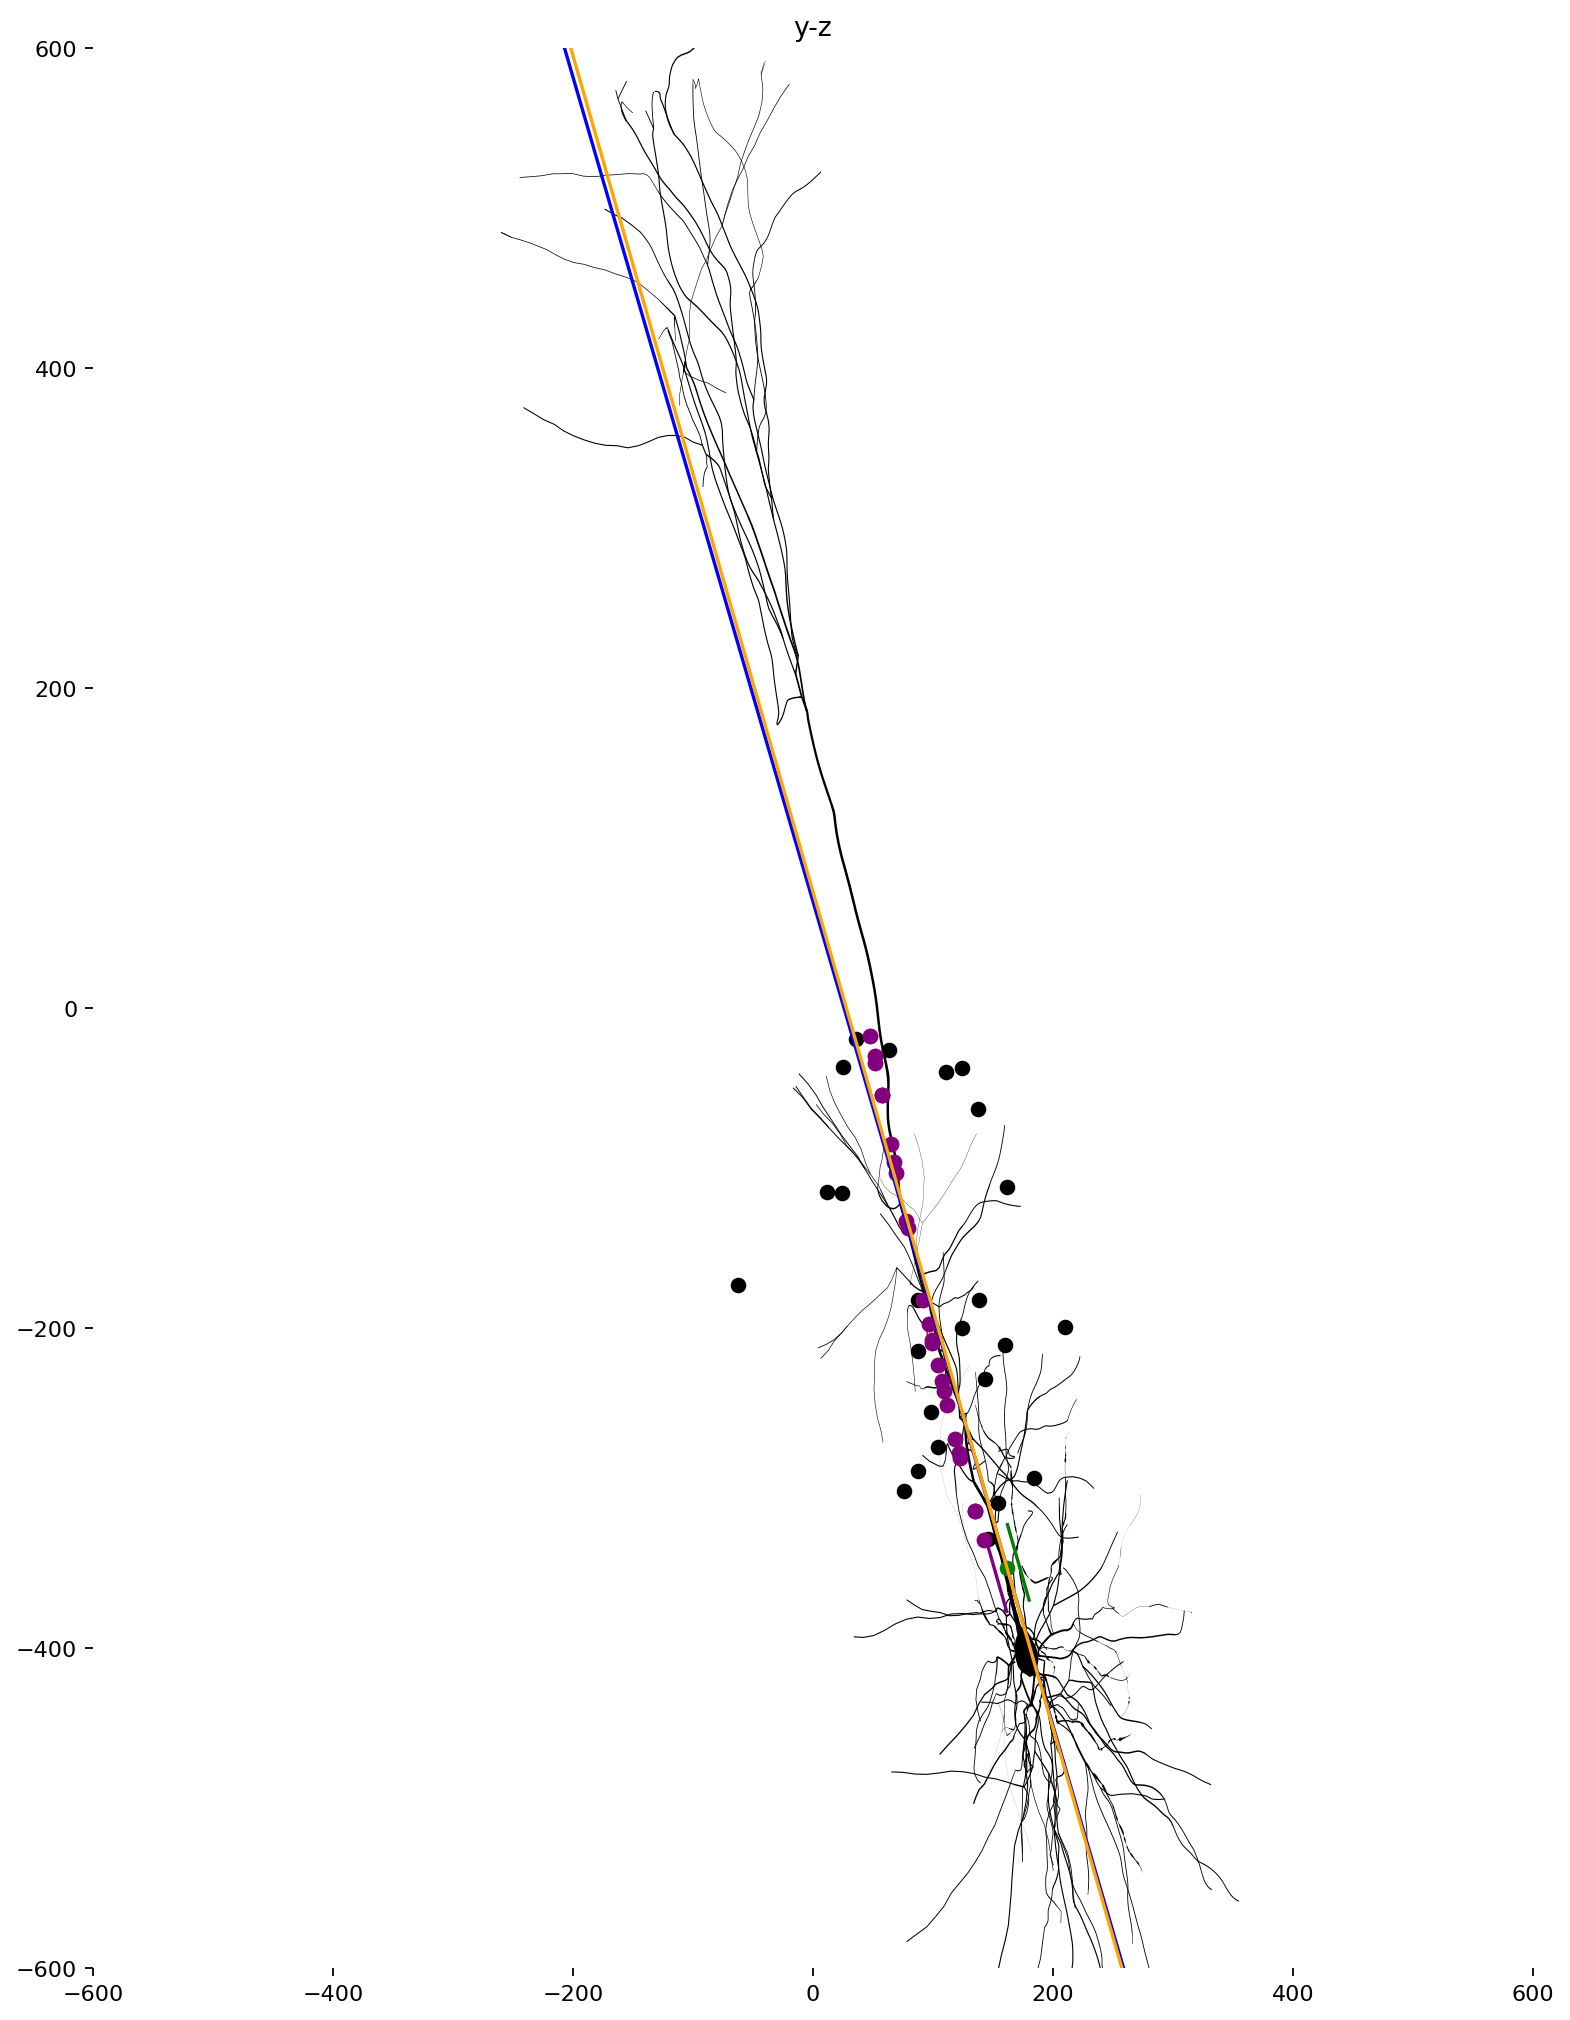

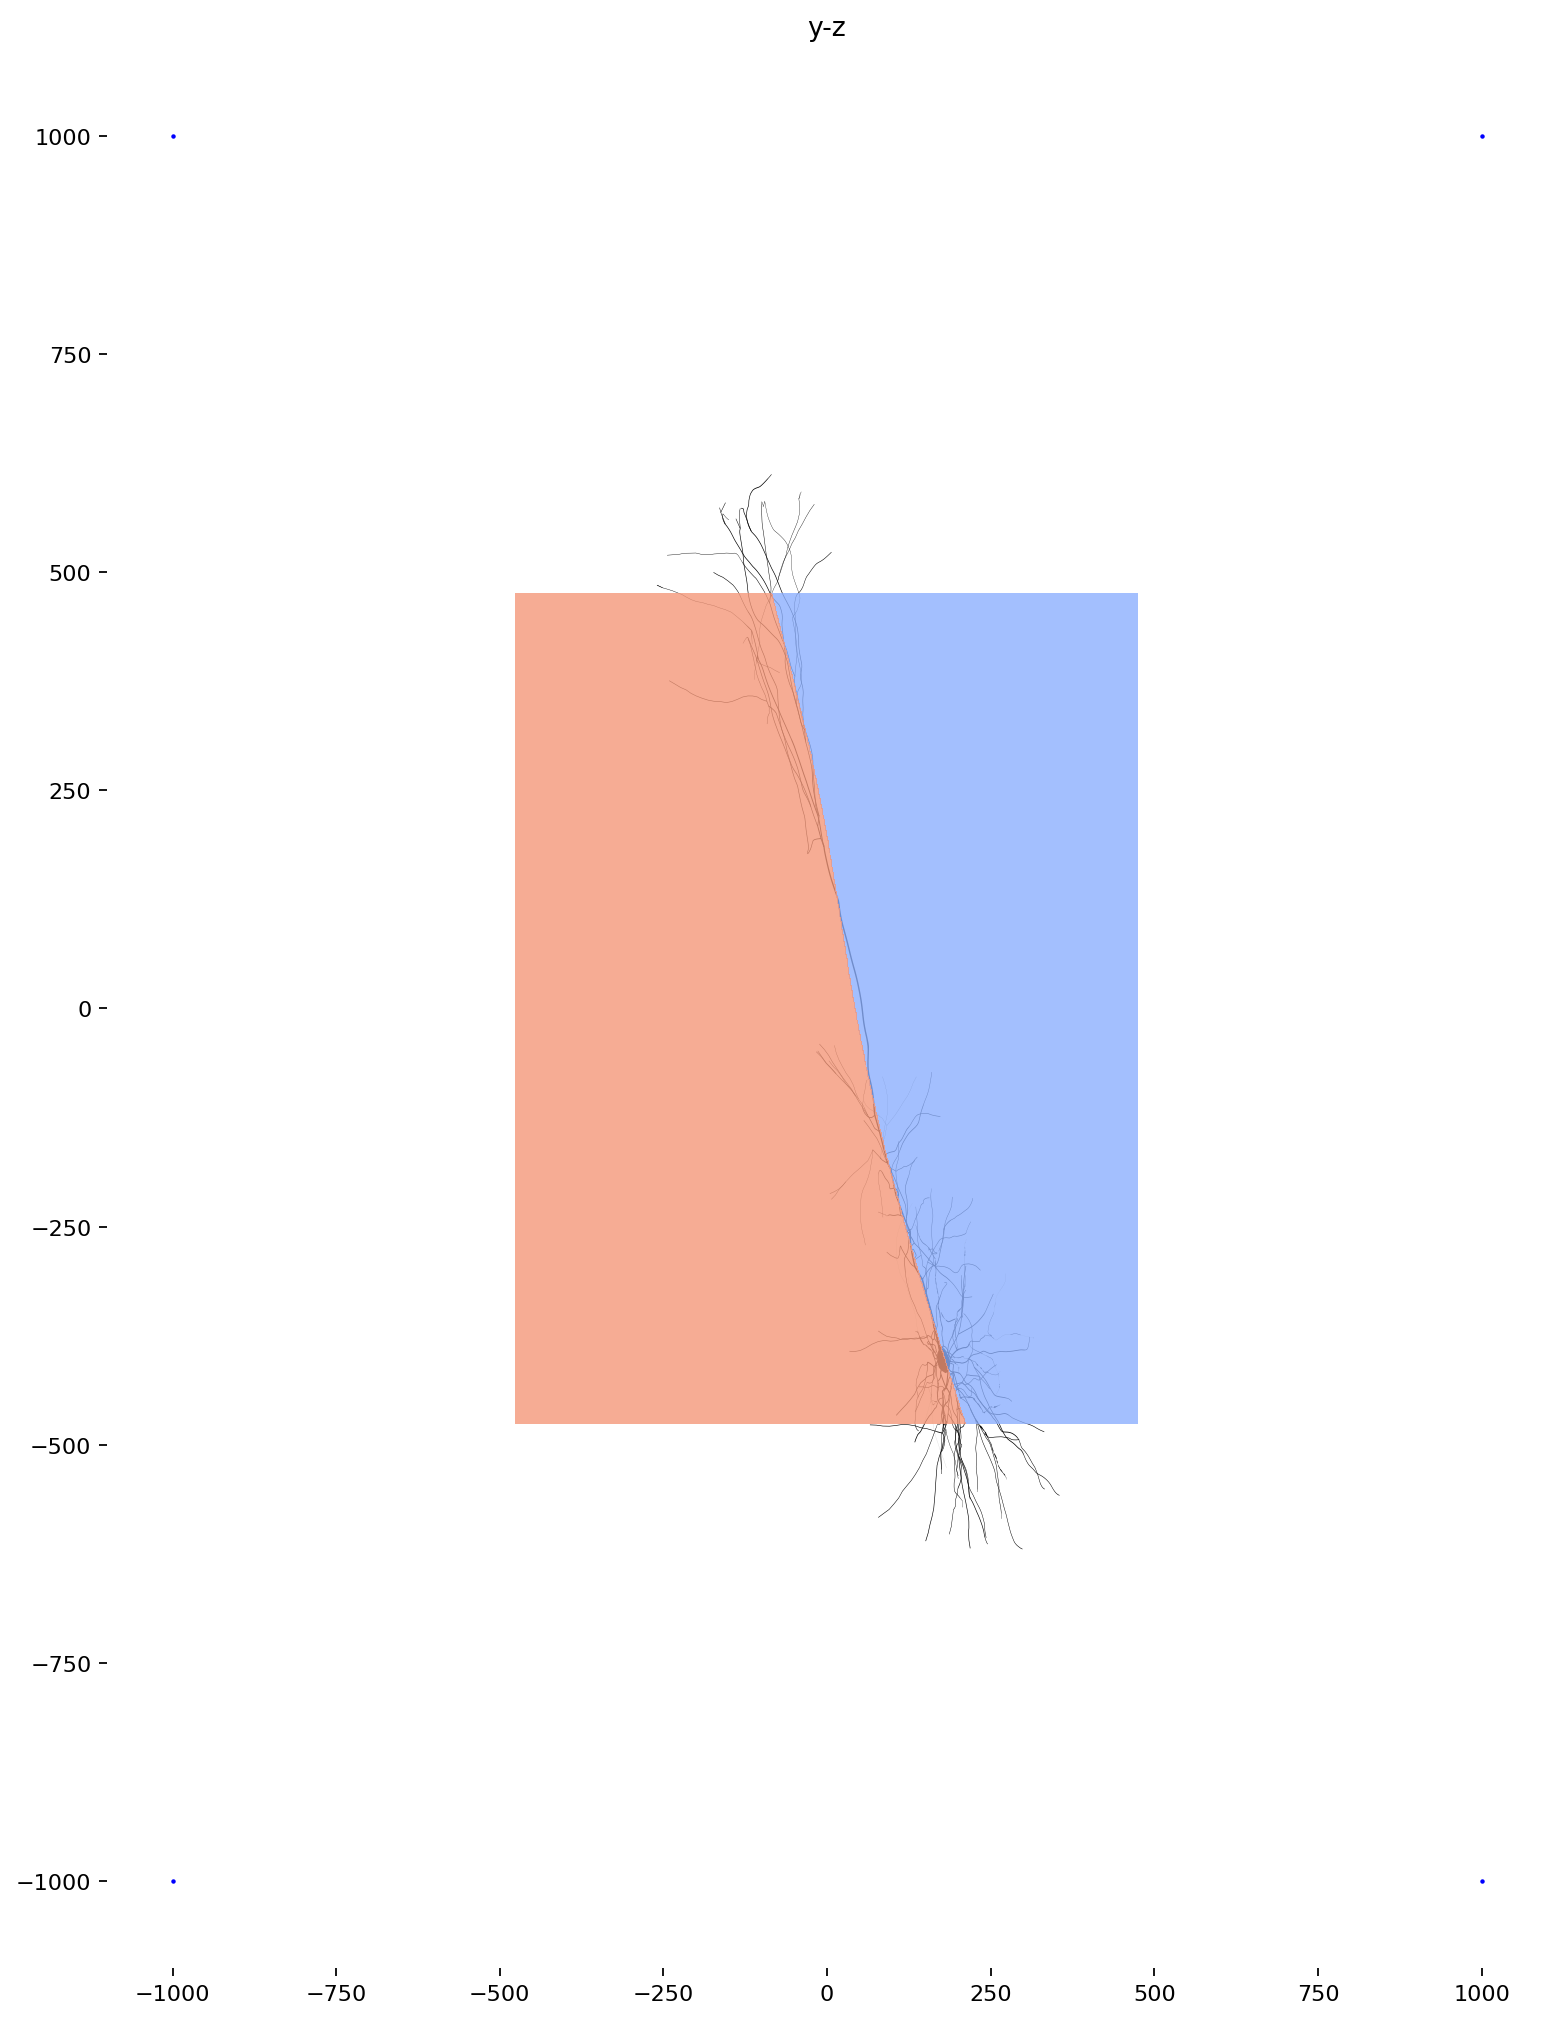

In [8]:
# Compute modified SVM for single cell
file_prefix = 'mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_'
mea_name = '400MEA50'
snr = 20
thresh = 0
template_id = 0
plot = True

# Modified SVM parameters
params = {}
params['min_dist'] = -25
params['max_dist'] = 25
params['num_points'] = 1000
params['opp_dist'] = 10
params['weight'] = 100
params['epsilon'] = 1.2
params['max_range'] = 50

# Load actual coordinates of cell
with open(f'{file_prefix}{mea_name}.npy', 'rb') as f:
    all_y = np.load(f)
    all_z = np.load(f)
    mags = np.load(f)

# Get electrode coordinates
elec_x, elec_y = get_electrodes2(mea_name)
xx, yy = make_meshgrid(np.array(elec_x), np.array(elec_y), h=1)

# Generate noise according to SNR parameter
noise = generate_noise(snr, mags[template_id], np.shape(mags[template_id]))

# Extract signals with magnitude that exceeds threshold
signals = mags[template_id] + noise
coords, targets = get_strong_signals(signals, elec_x, elec_y, thresh)

# Apply SVM to coordinates of strong signals 
model = svm.SVC(kernel="rbf")
clf = model.fit(coords, targets)
boundary = get_boundary_coords(xx, yy, clf)
dist, std, all_dists = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = boundary)
print("Original dist: ", dist)

# Plot original SVM
tempgen = mr.tools.load_templates('ziad_mearec_templates/' + file_prefix + mea_name + '.h5', verbose=False)
cell = load_cell(template_id, tempgen)
if plot:
    fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
    ax.set_xlim([-600, 600])
    ax.set_ylim([-600, 600])
    #out, Z = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
Z = (Z != 0)

# Generate modified coordinates
# mod_coords, mod_targets = gen_modified_coords(clf, signals, elec_x, elec_y, xx, yy, coords, params)
# mod_model = svm.SVC(kernel='rbf')
# mod_clf = mod_model.fit(mod_coords, mod_targets)

# Estimate axon hillock and plot
ah_x, ah_y, new_coords = estimate_axon_hillock(signals, elec_x, elec_y, return_med = True)

# mult = 2
# fit_coords = np.zeros((len(new_coords)*(mult+1), 2))
# fit_coords[:len(new_coords)*mult, 0] = ah_x
# fit_coords[:len(new_coords)*mult, 1] = ah_y
# fit_coords[len(new_coords)*mult:, 0] = new_coords[:, 0]
# fit_coords[len(new_coords)*mult:, 1] = new_coords[:, 1]
# m, b = np.polyfit(fit_coords[:, 0], fit_coords[:, 1], 1)

weight = 100
eps = 1.25
indices = np.arange(4, 100, 4)
new_coords = get_lbf_points(signals, indices, elec_x, elec_y)
if plot:
    ax.scatter(ah_x, ah_y, color='green')
    ax.scatter(new_coords[:, 0], new_coords[:, 1], color='black')
    
cast_coords = cast_lbf_to_boundary(new_coords, boundary)

ax.scatter(cast_coords[:, 0], cast_coords[:, 1], color='red')

# Remove outliers
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(cast_coords)
distances, indices = nbrs.kneighbors(cast_coords)
avg_dists = np.mean(distances[:, 1:], axis=1)
max_range = 50
cast_coords_no_outliers = []
for i in range(len(avg_dists)):
    if avg_dists[i] < max_range:
        cast_coords_no_outliers.append(cast_coords[i])
cast_coords = np.array(cast_coords_no_outliers)

ax.scatter(cast_coords[:, 0], cast_coords[:, 1], color='purple')

m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Huber', weight, eps = eps)
line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

if plot:
    ax.plot(line_x_coords, m*line_x_coords + b, color = 'blue')
    
m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight)
line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

if plot:
    ax.plot(line_x_coords, m*line_x_coords + b, color = 'orange')
    
# weight = 1000
# fit_coords = np.zeros((len(new_coords)+1, 2))
# fit_coords[0, 0] = ah_x
# fit_coords[0, 1] = ah_y
# fit_coords[1:, 0] = new_coords[:, 0]
# fit_coords[1:, 1] = new_coords[:, 1]
# weights = np.ones((len(new_coords)+1,))
# weights[0] = weight
# m, b = np.polyfit(fit_coords[:, 0], fit_coords[:, 1], 1, w = weights)

# line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

# if plot:
#     ax.plot(line_x_coords, m*line_x_coords + b, color = 'orange')

q = yy > (xx*m + b)
print(np.unique(Z))
greater_than_category = np.sum(q & Z)/np.sum(q) > 0.5

# Points close to axon_hillock along line of best fit
nearby_dists = np.arange(-5, 5.1, 0.01)*5

# Find closest point to (ah_x, ah_y) on line
b2 = ah_y + ah_x/m
ah_x2 = (b2 - b)/(m + 1/m)
ah_y2 = m*ah_x2 + b
print(ah_x, ah_x2)

# Get nearby points along line of best fit
nearby_x = nearby_dists/np.sqrt(1 + m**2) + ah_x2
nearby_y = m*nearby_x + b

print(np.sqrt((nearby_x - ah_x2)**2 + (nearby_y - (ah_y2))**2))

# Get one point one either side of each of those points along the line perpendicular to line of best fit
b_vals = nearby_y + nearby_x/m
opposite_dists = np.arange(-2, 2.1, 4)*5
opposite_x = np.add.outer(opposite_dists/np.sqrt(1 + (1/m)**2), nearby_x)
b_vals = np.ones(np.shape(opposite_x)) * b_vals
opposite_y = -1*opposite_x / m + b_vals

if plot:
    ax.plot(opposite_x[0, :], opposite_y[0, :], color='purple')
    ax.plot(opposite_x[1, :], opposite_y[1, :], color='green')

#     ax.contourf(xx, yy, q, alpha = 0.4)

# Re-calculate SVM with modified coordinates
mod_coords = np.zeros((len(coords)+np.shape(opposite_x)[1]*np.shape(opposite_x)[0], 2))
mod_coords[:len(coords), :] = coords
mod_coords[len(coords):len(coords)+len(opposite_x[0]), 0] = opposite_x[0, :]
mod_coords[len(coords):len(coords)+len(opposite_x[0]), 1] = opposite_y[0, :]
mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 0] = opposite_x[1, :]
mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 1] = opposite_y[1, :]

mod_targets = np.zeros((len(mod_coords),))
mod_targets[:len(targets)] = targets[:]
mod_targets[len(targets):np.shape(opposite_x)[1] + len(targets)] = not greater_than_category
mod_targets[len(targets) + np.shape(opposite_x)[1]:np.shape(opposite_x)[1]*2 + len(targets)] = greater_than_category

sample_weights = np.ones((len(mod_targets),))
sample_weights[len(targets):] = 1

# mod_model = svm.SVC(kernel="rbf")
# mod_clf = mod_model.fit(mod_coords, mod_targets)
# mod_boundary = get_boundary_coords(xx, yy, mod_clf)
# dist, std, all_dists_mod = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = mod_boundary)
# print("Modified dist: ", dist)

# if plot:
#     fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
#     out, Z = plot_contours(ax, mod_clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

# print("Original Dists: ", all_dists[:10])
# print("Modified Dists: ", all_dists_mod[:10])

mod_coords3, mod_targets3 = get_modified_cords3(m, b, coords, targets, cast_coords, ah_x2, ah_y2)
#mod_coords3, mod_targets3 = 

mod_model3 = svm.SVC(kernel="rbf")
mod_clf3 = mod_model3.fit(mod_coords3, mod_targets3)
mod_boundary3 = get_boundary_coords(xx, yy, mod_clf3)
dist, std, all_dists_mod = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = mod_boundary3)
print("Modified dist3: ", dist)

if plot:
    fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
    out, Z = plot_contours(ax, mod_clf3, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

In [19]:
def plotSensors(cell, t, data, electrodes, dim, mag, real_morph, scale_mult, time_scale, clf, xx, yy, **params):
    '''plotting'''
    plot_full_cell = False
    fig = plt.figure(dpi=1080)
    
    ax1 = fig.add_axes([0.05, 0.1, 0.55, 0.9], frameon=False)
    #cax = fig.add_axes([0.05, 0.115, 0.55, 0.015])
    
    if plot_contours:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax1.contourf(xx, yy, Z, **params)
    
    # Plot electrode positions
#     ax1.plot(electrodes.y, electrodes.z, '.', marker='.', markersize=1, color='k', zorder=0)
    if plot_full_cell:
        max_y, min_y, max_z, min_z = get_cell_extents(cell)
        ax1.plot([max_y, min_y], [max_z, min_z], '.', marker='o', markersize=0.5, color="white", zorder=1)
    
    #normalize to max peak
    maxs = np.ones((np.shape(data)[0], 1))
    maxs = maxs * np.abs(data).max()
    maxs = np.squeeze(maxs)
    LFPnorm = (data.T / maxs).T
        
    # Calculate time scale to adjust width of traces to fit perfectly between plotted electrodes
    
    # Find distance along y axis between electrodes
    start_y = electrodes.y[0]
    delta_y = 0
    for i in range(1, len(electrodes.y)):
        if electrodes.y[i] != start_y:
            delta_y = electrodes.y[i] - start_y
            break
    
    # Adjust time_scale to fit within 80% of distance between electrodes
#     time_scale = 10
    if delta_y > 0 and time_scale == 0:
        delta_t = t[-1]-t[0]
        time_scale = delta_y/delta_t*0.8
        
    zips = []
    zips2 = []
    
    colors1 = []
    colors2 = []
#     for i in range(len(data)):
#         if np.max(data[i]) > abs(np.min(data[i])):
#             colors.append('green')
#         else:
#             colors.append('orange')
    
    #color2 = '#E69F00'
    color2 = '#CC79A7'
    color1 = '#332288'
    for i in range(len(LFPnorm)):
        if np.max(abs(LFPnorm[i])) > 0.015:
            zips.append(list(zip((t-t[0])*time_scale + electrodes.y[i], LFPnorm[i]*scale_mult+electrodes.z[i])))
            if np.max(data[i]) > abs(np.min(data[i])):
                colors1.append(color1)
            else:
                colors1.append(color2)
        else:
            zips2.append(list(zip((t-t[0])*time_scale + electrodes.y[i], LFPnorm[i]*scale_mult+electrodes.z[i])))
            if np.max(data[i]) > abs(np.min(data[i])):
                colors2.append(color1)
            else:
                colors2.append(color2)
        #ax1.plot((t-t[0])*time_scale + electrodes.y[i], LFPnorm[i]*scale_mult+electrodes.z[i])
    #cmap used to be nipy-spectral
    line_segments = LineCollection(zips,
                                   linewidths = (1),
                                   linestyles = 'solid',
                                   colors = colors1,
                                   zorder=3,
                                   rasterized=False)
    line_segments2 = LineCollection(zips2,
                                   linewidths = (1),
                                   linestyles = 'solid',
                                   colors = colors2,
                                   alpha = 0.2,
                                   zorder=3,
                                   rasterized=False)
    # set_array enables color scaling - done according to log of peak value for each trace
    scale_factor = 1 # Scales from mV for electrical recordings
    if mag == True:
        scale_factor = 1e12 # Scales from pT for magnetic recordings
    max_vals = np.abs(data*scale_factor).max(axis=1)
    line_segments.set_array(np.log10(max_vals))
    line_segments2.set_array(np.log10(max_vals))
    ax1.add_collection(line_segments)
    ax1.add_collection(line_segments2)
    
    # add color bar
#     axcb = fig.colorbar(line_segments, cax=cax, orientation='horizontal')
#     axcb.outline.set_visible(False)

#     # set color bar ticks to correspond to actual peak values (invert the logarithm)
#     xticks = axcb.get_ticks()
#     xticks = np.append(xticks, np.log10(np.abs(data).max()*scale_factor))
#     axcb.set_ticks(xticks)
#     axcb.set_ticklabels(np.round(10**xticks, decimals=2))
#     axcb.set_label('spike amplitude (mV)', va='center')
#     if mag == True:
#         axcb.set_label('spike amplitude (pT)', va='center')
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    axis = ax1.axis(ax1.axis('equal'))
    ax1.set_xlim(axis[0]*1.02, axis[1]*1.02)
    
    # plot morphology
    if cell != None:
        pt3d_polygons = []
        if real_morph == False:
            for sec in cell.allseclist:
                x = []
                y = []
                d = []
                for i in range(sec.n3d()):
                    x.append(sec.x3d(i))
                    y.append(sec.y3d(i))
                    d.append(sec.diam3d(i))
                polys = create_polygon2(x, y, d)
                pt3d_polygons.append(polys)
        else:
            print("Real morph")
            pt3d_polygons = cell.get_pt3d_polygons(projection=('y', 'z'))
    
        zips = []
        for x, y in pt3d_polygons:
            zips.append(list(zip(x, y)))
        from matplotlib.collections import PolyCollection
        polycol = PolyCollection(zips, edgecolors='none', facecolors='black', rasterized=False)
        ax1.add_collection(polycol)

#         ax1.text(-0.05, 0.95, 'a',
#                  horizontalalignment='center',
#                  verticalalignment='center',
#                  fontsize=16, fontweight='demibold',
#                  transform=ax1.transAxes)

    return fig, ax1

Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Morphology:  morphology/dend-C060114A2_axon-C060114A5.asc
Type:  <class 'str'>
Morphology is a string
Real morph


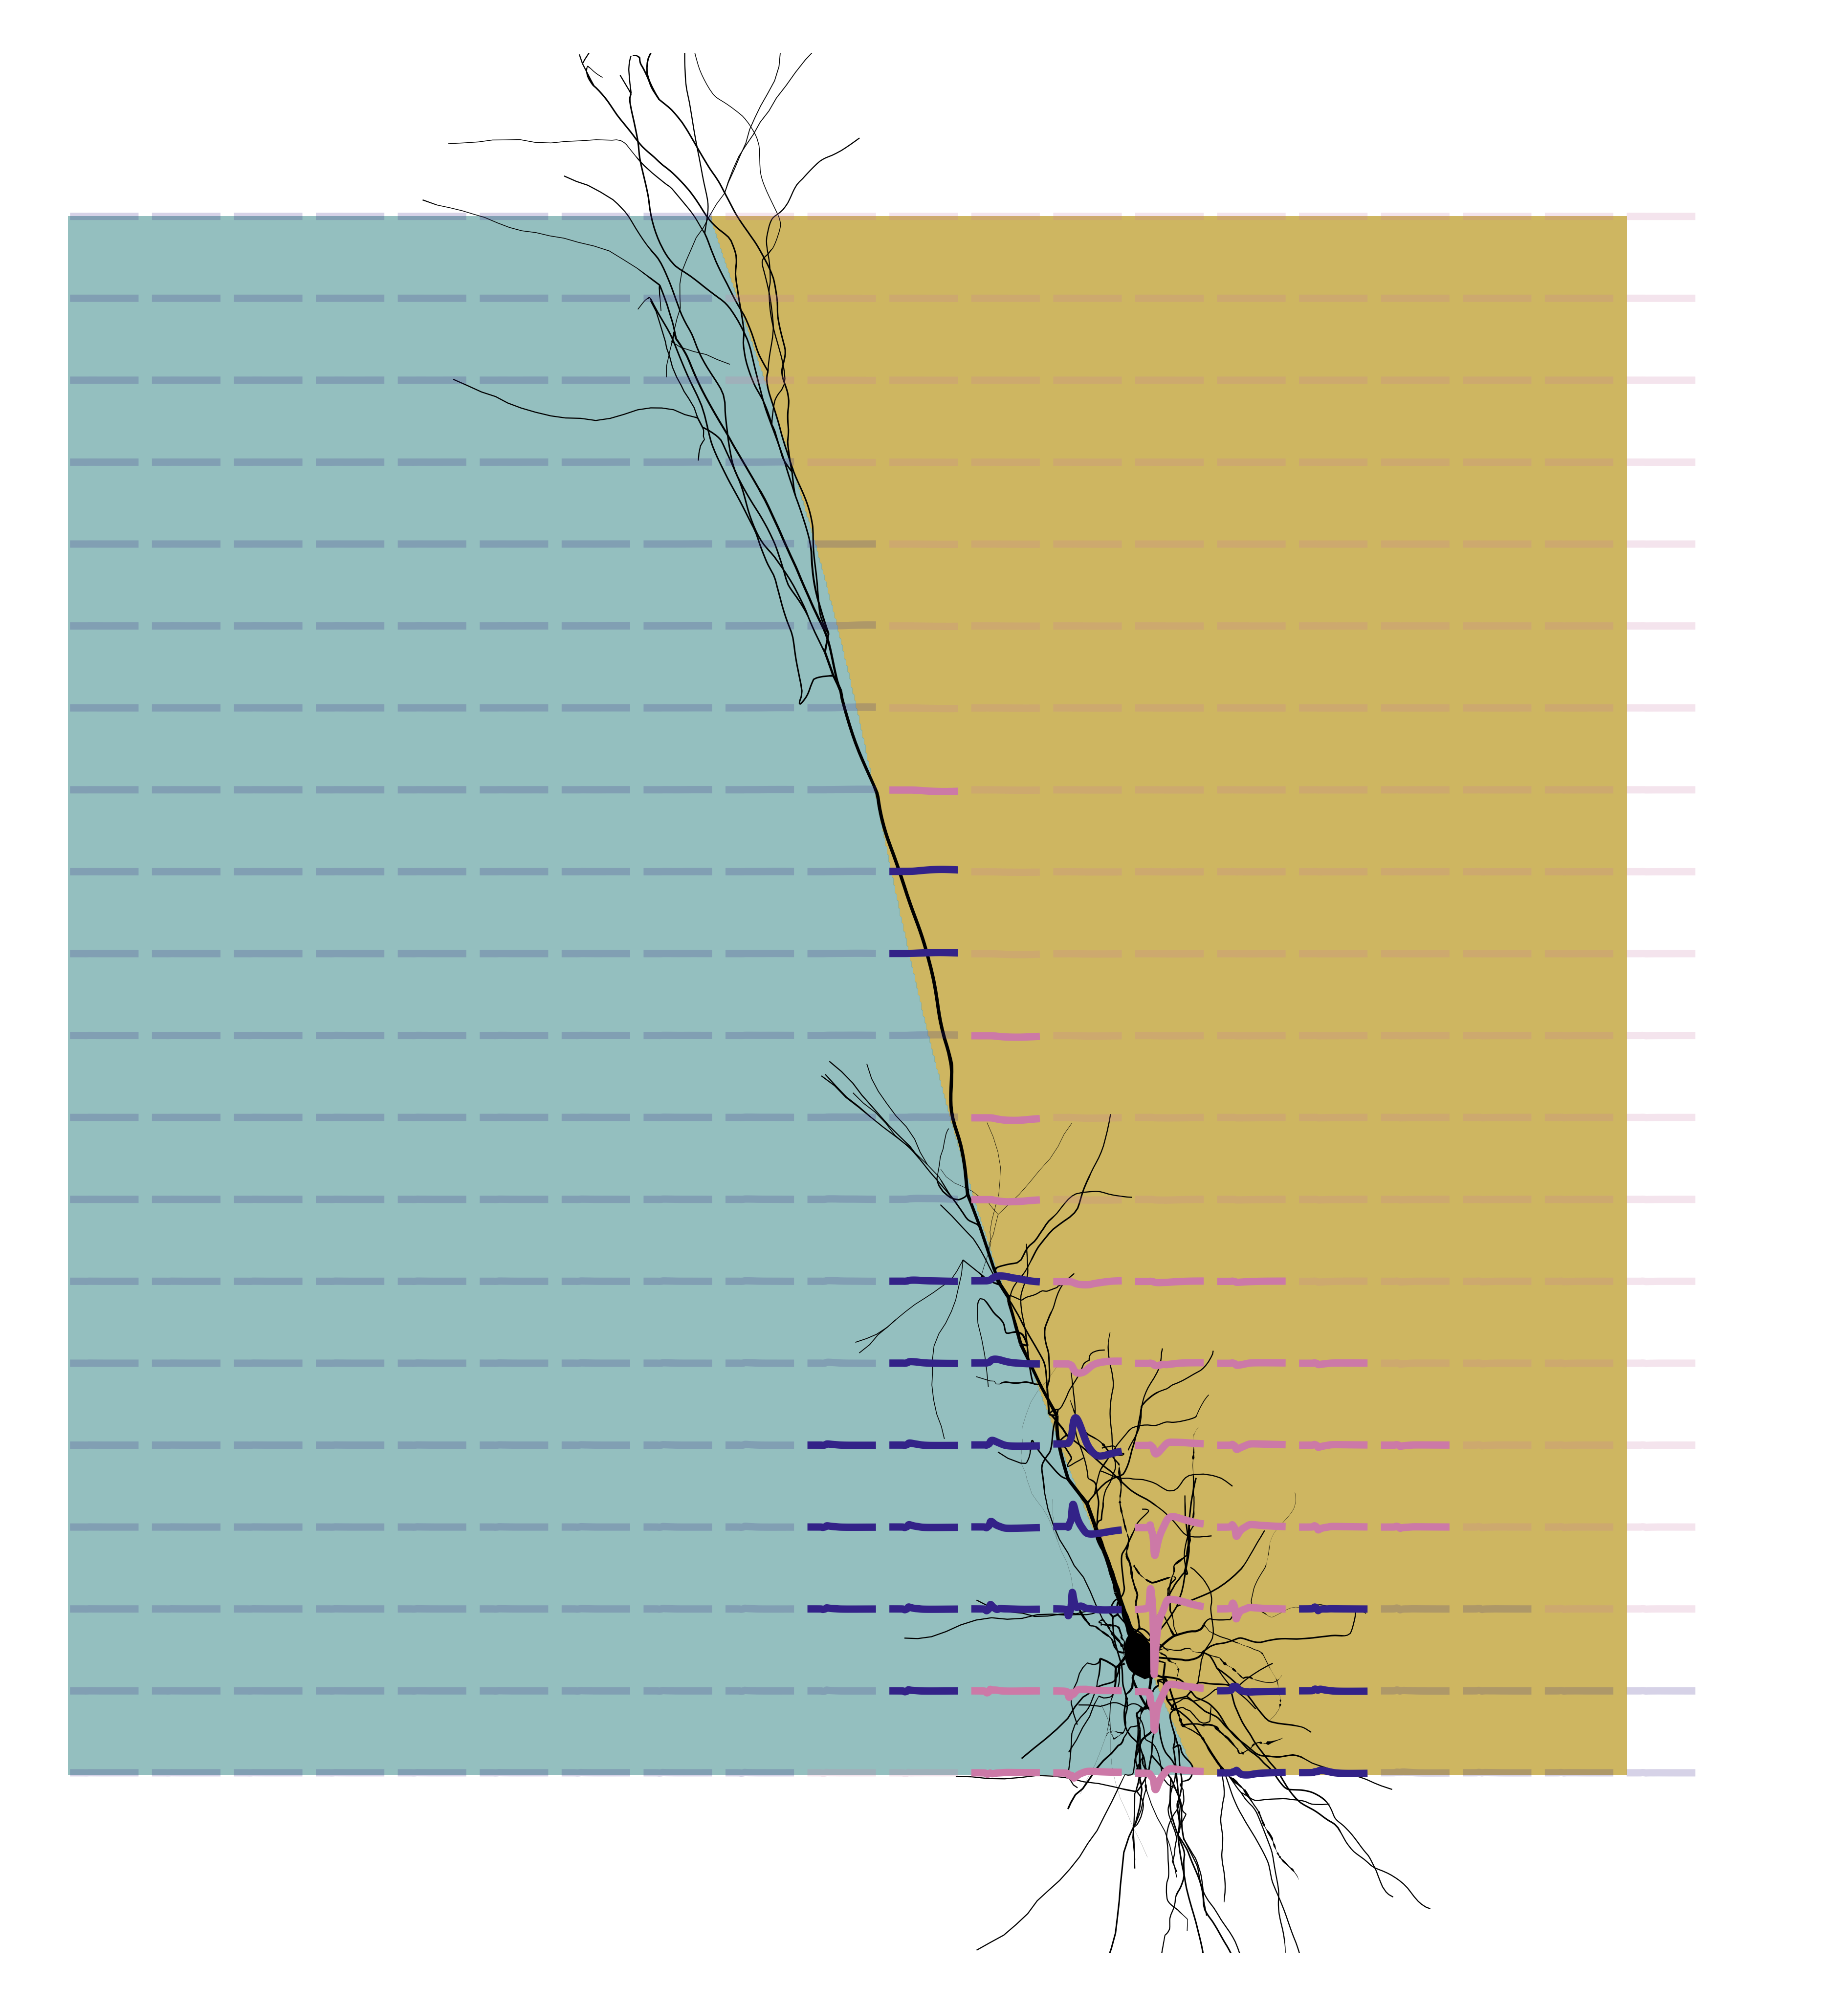

In [21]:
# fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
# out, Z = plot_contours(ax, mod_clf3, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
electrodes = get_electrodes('400MEA50')
real_morph = True
scale_mult = 40
time_scale = 6
dt = 0.03125
t = np.arange(0, 7, dt)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#E69F00","#56B4E9"])
#fig, ax1 = plotSensors(cell, t, mags[template_id, :, :], electrodes, 0, False, real_morph, scale_mult, time_scale, mod_clf3, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
fig, ax1 = plotSensors(cell, t, mags[template_id, :, :], electrodes, 0, False, real_morph, scale_mult, time_scale, mod_clf3, xx, yy, cmap=cmap, alpha=0.8)

#plot_contours2(ax1, mod_clf3, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

folder = '../../../../SimPaper/Morphology/'
plt.savefig(f'{folder}SVMExample.pdf', dpi=600, bbox_inches='tight')

In [1]:
# fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
# out, Z = plot_contours(ax, mod_clf3, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
electrodes = get_electrodes('400MEA50')
real_morph = True
scale_mult = 40
time_scale = 6
dt = 0.03125
t = np.arange(0, 7, dt)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#E69F00","#56B4E9"])
#fig, ax1 = plotSensors(cell, t, mags[template_id, :, :], electrodes, 0, False, real_morph, scale_mult, time_scale, mod_clf3, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
fig, ax1 = plotSensors(cell, t, mags[template_id, :, :], electrodes, 0, False, real_morph, scale_mult, time_scale, mod_clf3, xx, yy, cmap=cmap, alpha=0.8)

#plot_contours2(ax1, mod_clf3, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)


NameError: name 'get_electrodes' is not defined

In [60]:
def plot_contours2(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out, Z

In [7]:
def get_modified_cords3(m, b, target_coords, targets, cast_coords, ah_x2, ah_y2):
#     pwrs = np.sum(signals**2, axis=1)
#     idxs = np.flip(np.argsort(pwrs))

#     fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
#     ax.scatter(elec_x[idxs[:20]], elec_y[idxs[:20]], color='blue')
#     ax.scatter(elec_x[idxs[20:50]], elec_y[idxs[20:50]], color='green')
#     ax.scatter(elec_x[idxs[50:200]], elec_y[idxs[50:200]], color='red')
#     indices = np.arange(4, 100, 4)
#     new_coords = get_lbf_points(signals, indices, elec_x, elec_y)
#     ax.scatter(new_coords[:, 0], new_coords[:, 1], color='black')

    # Create vector pointing 1 um away in x along line of best fit
    vec = np.zeros((2, 1))
    vec[0, 0] = 1
    vec[1, 0] = m
    cast_coords_vecs = np.copy(cast_coords)

    # Get vectors pointing from AH to each point
    cast_coords_vecs[:, 0] -= ah_x2
    cast_coords_vecs[:, 1] -= ah_y2

    # Find projections from vectors onto LBF vector
    projections = np.matmul(cast_coords_vecs, vec)
    projections = projections > 0
    if np.sum(projections)/len(projections) < 0.5:
        vec *= -1

    vec = vec / np.sqrt(np.sum(vec**2))

    # Get point 10 um behind current point in opposite of vector direction
    behind_ah = -10*vec 
    bahx = behind_ah[0, 0] + ah_x2
    bahy = behind_ah[1, 0] + ah_y2
    remove_greater_than = True
    if behind_ah[1, 0] < 0:
        remove_greater_than = False

    perp_m = -1/m
    perp_b = bahy - perp_m*bahx
    
    new_target_coords = []
    new_targets = []
    
    for i, coord in enumerate(target_coords):
        if (coord[1] > coord[0]*perp_m + perp_b) != remove_greater_than:
            new_target_coords.append(coord)
            new_targets.append(targets[i])
            
    return np.array(new_target_coords), np.array(new_targets)

#     ax.scatter(ah_x, ah_y, color='green')
#     ax.plot(line_x_coords, perp_m*line_x_coords + perp_b, color = 'brown')
#     ww = (yy > (xx*perp_m + perp_b)) == remove_greater_than
#     ax.contourf(xx, yy, ww, color = 'orange', alpha = 0.4)

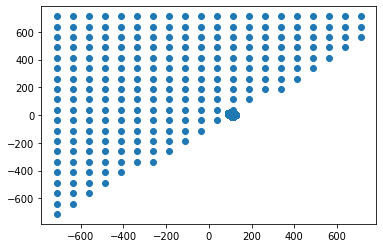

In [70]:
mod_coords3, mod_targets3 = get_modified_cords3(m, b, mod_coords, mod_targets, cast_coords, ah_x2, ah_y2)
plt.scatter(mod_coords3[:, 0], mod_coords3[:, 1])

In [41]:
# Create vector pointing 1 um away in x along line of best fit
vec = np.zeros((2, 1))
vec[0, 0] = 1
vec[1, 0] = m
cast_coords_vecs = np.copy(cast_coords)

# Get vectors pointing from AH to each point
cast_coords_vecs[:, 0] -= ah_x2
cast_coords_vecs[:, 1] -= ah_y2

# Find projections from vectors onto LBF vector
projections = np.matmul(cast_coords_vecs, vec)
projections = projections > 0
if np.sum(projections)/len(projections) < 0.5:
    vec *= -1

vec = vec / np.sqrt(np.sum(vec**2))

# Get point 10 um behind current point in opposite of vector direction
behind_ah = -10*vec 
bahx = behind_ah[0, 0] + ah_x2
bahy = behind_ah[1, 0] + ah_y2
remove_greater_than = True
if behind_ah[1, 0] < 0:
    remove_greater_than = False

perp_m = -1/m
perp_b = bahy - perp_m*bahx

ax.plot(line_x_coords, perp_m*line_x_coords + perp_b, color = 'brown')
ww = (yy > (xx*perp_m + perp_b)) == remove_greater_than
ax.contourf(xx, yy, ww, alpha = 0.4)

In [19]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(cast_coords)
distances, indices = nbrs.kneighbors(cast_coords)
avg_dists = np.mean(distances[:, 1:], axis=1)
print(np.shape(avg_dists))
print(np.shape(avg_dists[avg_dists < 50]))
print(indices)

(49,)
(44,)
[[ 0 34 32  4]
 [ 1 45 13  5]
 [ 2  5 26 39]
 [ 3 33 36  6]
 [ 4 32 34  0]
 [ 5  2 26 39]
 [ 6  3 33 47]
 [ 7 27 41  9]
 [28  8 25 15]
 [ 9 41 27  7]
 [10 14 15  8]
 [11 40 42 21]
 [12 17 19 37]
 [13 45  1  5]
 [14 10 15  8]
 [15  8 28 25]
 [16 47 18  6]
 [17 12 37 19]
 [18 16 47 35]
 [19 48 23 12]
 [20 46 36 38]
 [21 42 11 40]
 [22 30 13 45]
 [23 31 44 48]
 [24 43  1 45]
 [25 28  8 15]
 [26 39 40 11]
 [ 7 27 41  9]
 [28  8 25 15]
 [29 37 17 12]
 [30 22 13 45]
 [31 44 23 48]
 [32  4 34  0]
 [33  3 36  6]
 [ 0 34 32  4]
 [35 27  7 41]
 [36 33  3 20]
 [37 17 29 12]
 [38 46 20 44]
 [39 26 40 11]
 [40 11 39 21]
 [41  9 27  7]
 [21 42 11 40]
 [43 24  5  1]
 [44 31 23 48]
 [45  1 13  5]
 [46 20 38 36]
 [47 16 18  6]
 [48 23 31 44]]


[6.20201485] [711.35615046]
3.8625524871486423 535.3636293882597


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_50921/2497002300.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([xlim, xlim, -xlim, -xlim], [ylim, -ylim, ylim, -ylim], '.', marker='o', markersize=1, color='blue')


(-475.0, 475.0)

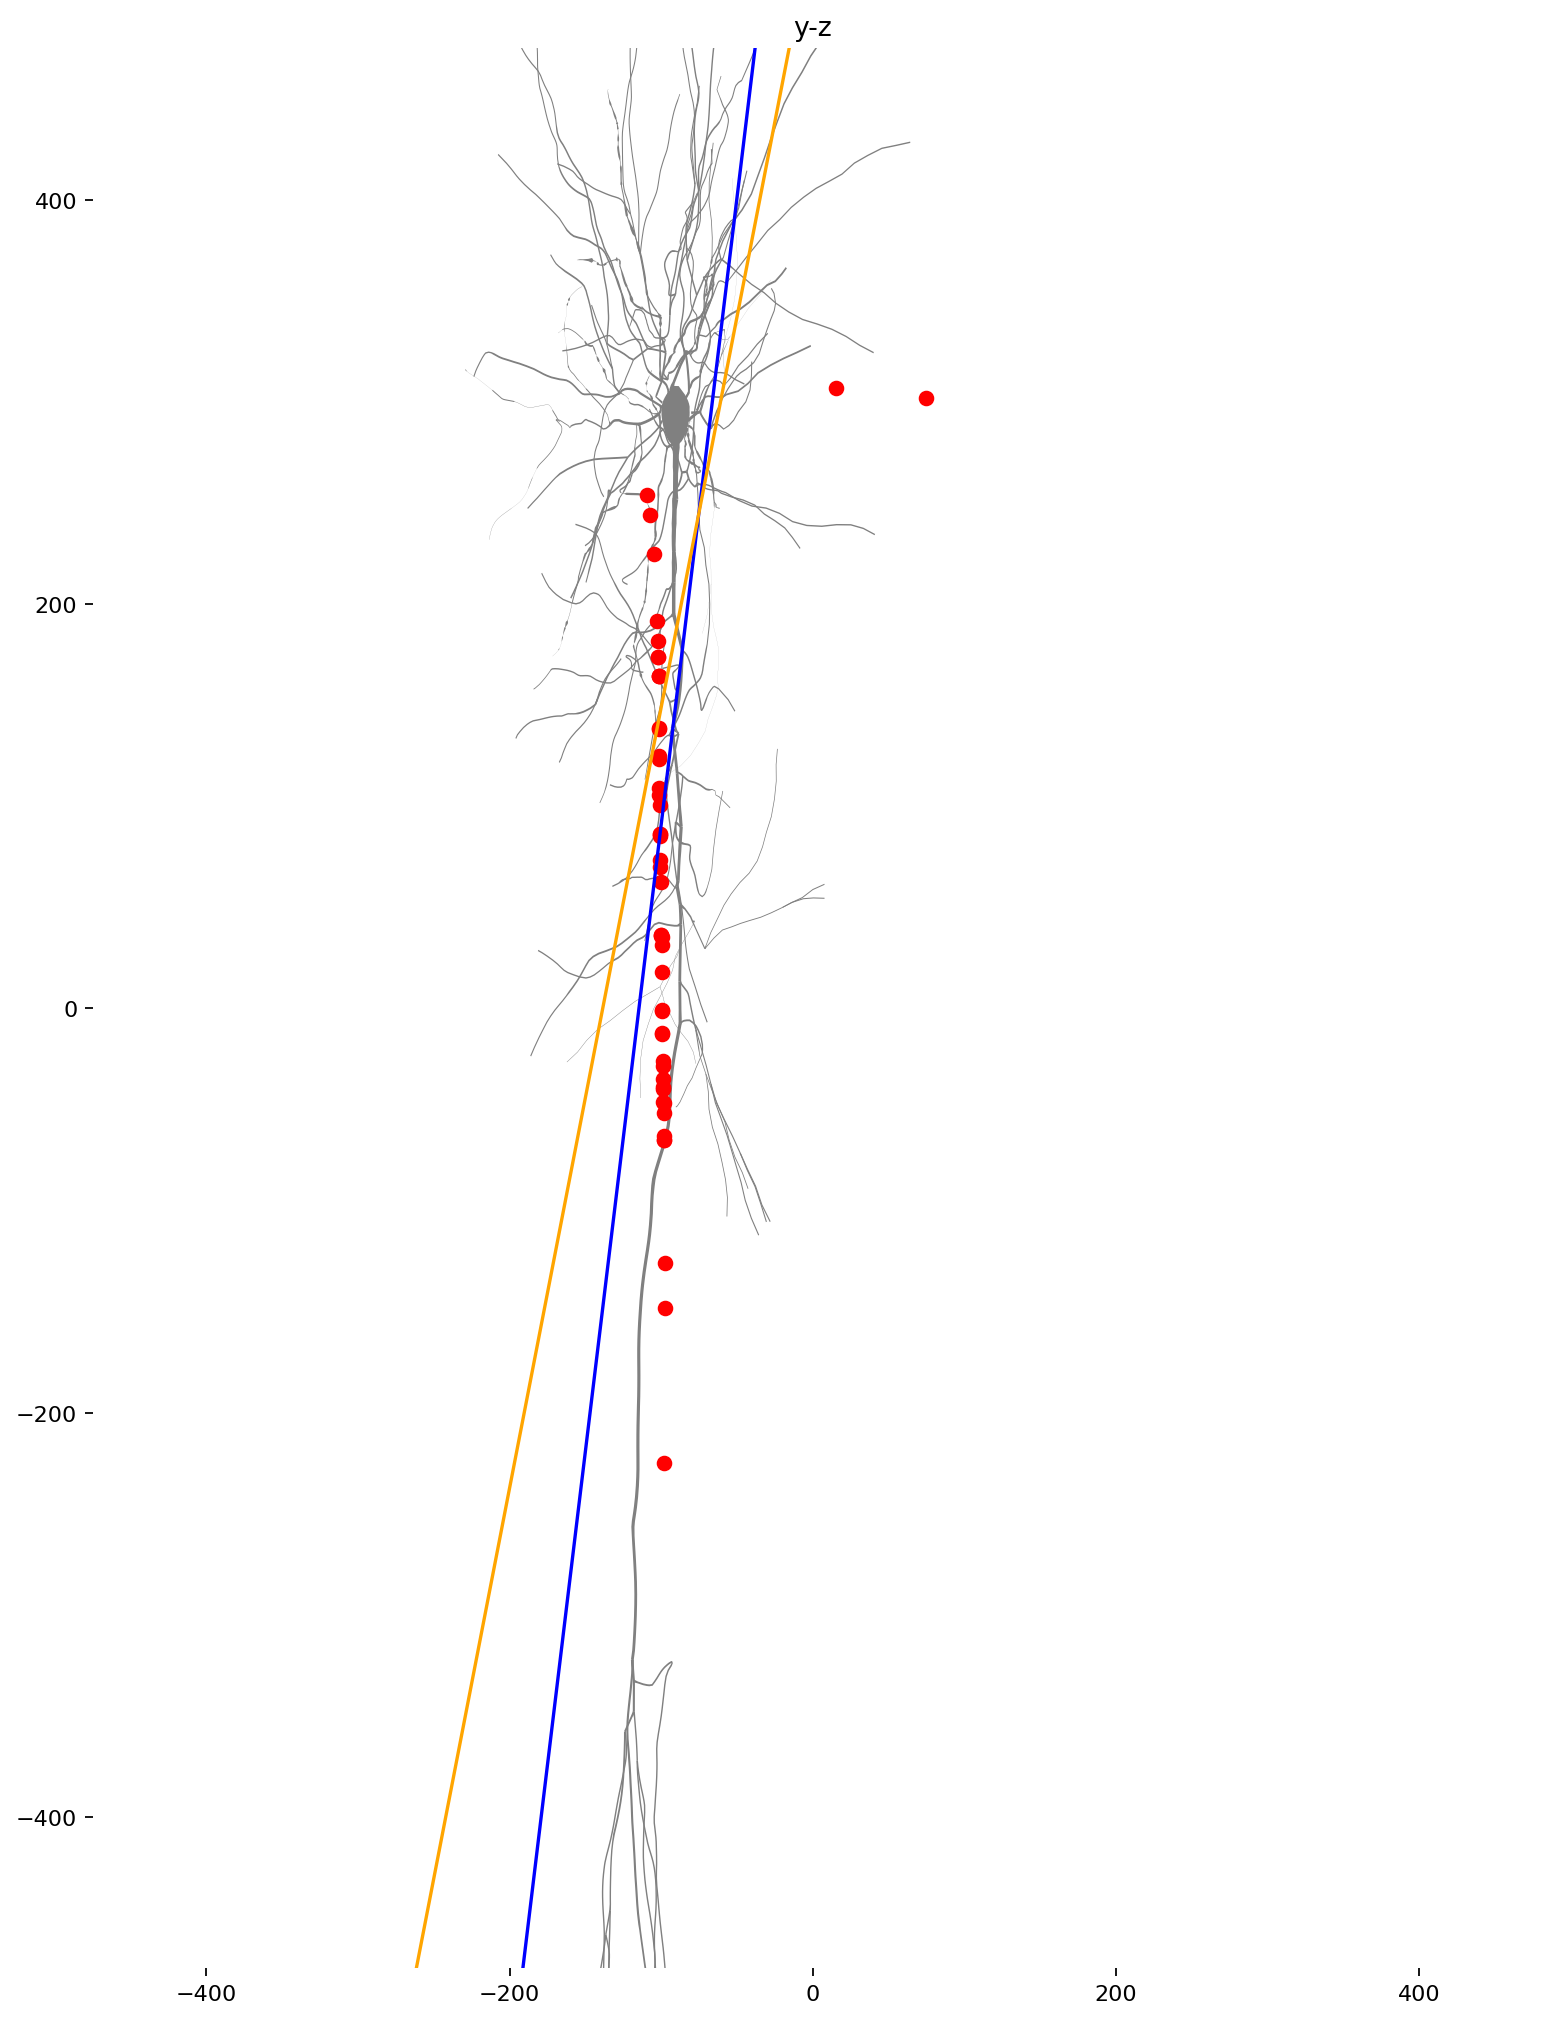

In [128]:
fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
#out, Z = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

weight = 100
indices = np.arange(4, 200, 4)
new_coords = get_lbf_points(signals, indices, elec_x, elec_y)
cast_coords = cast_lbf_to_boundary(new_coords, boundary)
ax.scatter(cast_coords[:, 0], cast_coords[:, 1], color='red')

m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Huber', weight, eps = 1.1)
print(m, b)
line_x_coords = np.linspace(-250, 150, 400)

if plot:
    plt.plot(line_x_coords, m*line_x_coords + b, color = 'blue')
    
m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight)
print(m, b)
line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

if plot:
    plt.plot(line_x_coords, m*line_x_coords + b, color = 'orange')
    
plt.xlim([-475, 475])
plt.ylim([-475, 475])

In [17]:
fig, ax = plotcell_1plane(cell, 1000, 1000)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

NameError: name 'cell' is not defined

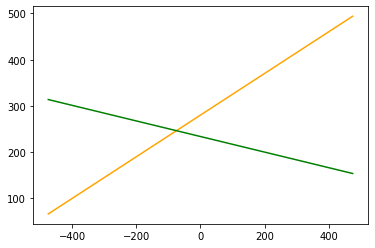

In [54]:
line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

m, b = calc_lbf(ah_x, ah_y, fit_coords[1:, :], 'Huber', 1000)
plt.plot(line_x_coords, m*line_x_coords + b, color = 'orange')

m, b = calc_lbf(ah_x, ah_y, fit_coords[1:, :], 'Normal', 1000)
plt.plot(line_x_coords, m*line_x_coords + b, color = 'green')

In [28]:
print(all_y[template_id, 0], all_z[template_id, 0])
soma = np.zeros((1, 2))
soma[0] = [all_y[template_id, 0], all_z[template_id, 0]]
print(boundary)
dist = distance.cdist(soma, boundary)
print(np.min(dist), np.argmin(dist))

42.77459716796875 -304.04217529296875
[[  35.25 -476.  ]
 [ 281.25 -476.  ]
 [  35.5  -475.75]
 ...
 [ 315.25  474.5 ]
 [ 315.25  475.  ]
 [ 315.25  475.5 ]]
101.85750876006766 1141


In [29]:
print(all_y[template_id, 0], all_z[template_id, 0])
soma = np.zeros((1, 2))
soma[0] = [all_y[template_id, 0], all_z[template_id, 0]]
print(boundary)
dist = distance.cdist(soma, mod_boundary)
print(np.min(dist), np.argmin(dist))

42.77459716796875 -304.04217529296875
[[  35.25 -476.  ]
 [ 281.25 -476.  ]
 [  35.5  -475.75]
 ...
 [ 315.25  474.5 ]
 [ 315.25  475.  ]
 [ 315.25  475.5 ]]
15.929971137942987 884


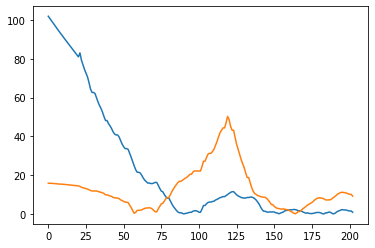

In [30]:
plt.plot(all_dists)
plt.plot(all_dists_mod)

In [13]:
a = np.zeros((3, 2))
a[0] = [0, 0]
a[1] = [2, 1]
a[2] = [-3, 2]

b = np.zeros((2, 2))
b[0] = [4, 5]
b[1] = [-4, 0]

np.min(distance.cdist(a, b), axis=1)

#get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = boundary)

array([4.        , 4.47213595, 2.23606798])

In [172]:
nearby_dists = np.arange(-5, 5.1, 1)

# Find closest point to (ah_x, ah_y) on line
b2 = ah_y + ah_x/m
ah_x2 = (b2 - b)/(m + 1/m)
ah_y2 = m*ah_x2 + b
print(ah_x, ah_x2)

# Get nearby points along line of best fit
nearby_x = nearby_dists/np.sqrt(1 + m**2) + ah_x2
nearby_y = m*nearby_x + b

print(np.sqrt((nearby_x - ah_x2)**2 + (nearby_y - (ah_y2))**2))

# Get one point one either side of each of those points along the line perpendicular to line of best fit
b_vals = nearby_y + nearby_x/m
opposite_dists = np.arange(-2, 2.1, 4)
print(nearby_x)
opposite_x = np.add.outer(opposite_dists/np.sqrt(1 + (1/m)**2), nearby_x)
b_vals = np.ones(np.shape(opposite_x)) * b_vals
opposite_y = -1*opposite_x / m + b_vals
print(opposite_y)

244.12238792845778 244.7829323408537
[5. 4. 3. 2. 1. 0. 1. 2. 3. 4. 5.]
[240.32043506 241.21293452 242.10543397 242.99793343 243.89043288
 244.78293234 245.6754318  246.56793125 247.46043071 248.35293017
 249.24542962]
[[-292.22210914 -292.67315761 -293.12420608 -293.57525454 -294.02630301
  -294.47735148 -294.92839995 -295.37944842 -295.83049689 -296.28154535
  -296.73259382]
 [-288.65211131 -289.10315978 -289.55420825 -290.00525672 -290.45630519
  -290.90735366 -291.35840212 -291.80945059 -292.26049906 -292.71154753
  -293.162596  ]]


In [193]:
np.shape(targets)

(400,)

In [191]:
mod_coords

array([[-475.        , -475.        ],
       [-475.        , -425.        ],
       [-475.        , -375.        ],
       [-475.        , -325.        ],
       [-475.        , -275.        ],
       [-475.        , -225.        ],
       [-475.        , -175.        ],
       [-475.        , -125.        ],
       [-475.        ,  -75.        ],
       [-475.        ,  -25.        ],
       [-475.        ,   25.        ],
       [-475.        ,   75.        ],
       [-475.        ,  125.        ],
       [-475.        ,  175.        ],
       [-475.        ,  225.        ],
       [-475.        ,  275.        ],
       [-475.        ,  325.        ],
       [-475.        ,  375.        ],
       [-475.        ,  425.        ],
       [-475.        ,  475.        ],
       [-425.        , -475.        ],
       [-425.        , -425.        ],
       [-425.        , -375.        ],
       [-425.        , -325.        ],
       [-425.        , -275.        ],
       [-425.        , -2

In [199]:
mod_targets = np.zeros((len(mod_coords),))
mod_targets[:len(targets)] = targets[:]
mod_targets[len(targets):np.shape(opposite_x)[1] + len(targets)] = not greater_than_category
mod_targets[len(targets) + np.shape(opposite_x)[1]:np.shape(opposite_x)[1]*2 + len(targets)] = greater_than_category
print(mod_targets[400:])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [200]:
greater_than_category

False

In [8]:
with open(f'mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_400MEA50.npy', 'rb') as f:
    all_y = np.load(f)
    all_z = np.load(f)
    mags = np.load(f)
    
elec_x, elec_y = get_electrodes2('400MEA50')

In [31]:
mags_pwr = np.sqrt(np.sum(mags[0]**2, axis=1))
mags_strong_indices = np.argsort(-1*mags_pwr)[:4]
mags_relative_pwr = mags_pwr[mags_strong_indices] / np.sum(mags_pwr[mags_strong_indices])

new_x = np.sum(elec_x[mags_strong_indices] * mags_relative_pwr)
new_y = np.sum(elec_y[mags_strong_indices] * mags_relative_pwr)

print(new_x, new_y)

161.80264149019138 -349.5288645466396


In [29]:
elec_x[mags_strong_indices] * mags_relative_pwr

array([54.40229825, 32.99339627, 38.81974123, 35.58720574])

### IGNORE EVERYTHING BELOW THIS POINT

In [45]:
dists_list = np.array(dists_list)
dists_std_list = np.array(dists_std_list)

print("Mean distance: ", np.mean(dists_list))
print("Mean std of dist: ", np.sqrt(np.mean(dists_std_list**2)))
print("Num fails: ", fails)

Mean distance:  65.34099260129712
Mean std of dist:  49.447791737789885
Num fails:  0


In [38]:
np.sqrt(np.mean(dists_std[:, 0]**2))

23.608866065726072

In [34]:
for i in range(len(dists)):
    mean_total = 0
    var_total = 0
    count = 0
    for j in range(len(dists[0])):
        if dists[i, j] < 1000000:
            mean_total += dists[i, j]
            var_total += dists_std[i, j]**2
            count += 1
    print(mean_total/count, '\t', np.sqrt(var_total/count))


50.0 	 12.0
25.651431416018383 	 14.581566836780036


In [33]:
dists[0, 1] = 60
dists[0, 2] = 1000000
dists_std[0] = 12

In [38]:
elec_y

array([-950., -850., -750., -650., -550., -450., -350., -250., -150.,
        -50.,   50.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,
        850.,  950., -950., -850., -750., -650., -550., -450., -350.,
       -250., -150.,  -50.,   50.,  150.,  250.,  350.,  450.,  550.,
        650.,  750.,  850.,  950., -950., -850., -750., -650., -550.,
       -450., -350., -250., -150.,  -50.,   50.,  150.,  250.,  350.,
        450.,  550.,  650.,  750.,  850.,  950., -950., -850., -750.,
       -650., -550., -450., -350., -250., -150.,  -50.,   50.,  150.,
        250.,  350.,  450.,  550.,  650.,  750.,  850.,  950., -950.,
       -850., -750., -650., -550., -450., -350., -250., -150.,  -50.,
         50.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,
        950., -950., -850., -750., -650., -550., -450., -350., -250.,
       -150.,  -50.,   50.,  150.,  250.,  350.,  450.,  550.,  650.,
        750.,  850.,  950., -950., -850., -750., -650., -550., -450.,
       -350., -250.,

In [39]:
electrodes = get_electrodes('400MEA75')
elec_x = electrodes.y
elec_y = electrodes.z

Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Morphology:  morphology/dend-C060114A2_axon-C060114A5.asc
Type:  <class 'str'>
Morphology is a string


In [51]:
len(elec_x)

400

In [55]:
a, b = get_electrodes2('400MEA75')

In [56]:
len(a)

400

In [49]:
np.arange(-1*max_coord, max_coord+1, pitch)

array([-712.5, -637.5, -562.5, -487.5, -412.5, -337.5, -262.5, -187.5,
       -112.5,  -37.5,   37.5,  112.5,  187.5,  262.5,  337.5,  412.5,
        487.5,  562.5,  637.5,  712.5])

In [29]:
l1 = 100
l2 = 300
a = np.random.random(l1)
b = np.random.random(l2)
c = np.zeros(l1+l2)
c[:l1] = a
c[l1:] = b

print(np.std(a))
print(np.std(b))
print(np.std(c))

0.28761582209056064
0.28452962072054616
0.286229148203436


In [32]:
print(np.sqrt((np.std(a)**2*(l1-1) + np.std(b)**2*(l2-1))/(l1+l2-2)))
print(np.sqrt((np.std(a)**2*(l1) + np.std(b)**2*(l2))/(l1+l2)))

0.28530041323707606
0.28530430084339886


In [21]:
w = 1e-3
r = 1e-3

I = 10000e-9
N = 100
mu_r = 1000
f = 1e3

B_flux = w*np.log((r+w)/r)*I*2e-7
print(B_flux)
print(I*2e-7/(r+w/2))

emf = N*mu_r*B_flux*f
print(emf*1e9, 'nV')

1.3862943611198907e-15
1.3333333333333333e-09
138.62943611198907 nV
